##Loader

In [ ]:
!pip install latextable
!pip install names
!pip install num2words

  Created wheel for latextable: filename=latextable-0.2.1-py3-none-any.whl size=6243 sha256=6b7d0d4b330bd8fd2159f5e95dd2ac2e28668a508a3b2d03b0a775a4fc4d6509
  Stored in directory: /root/.cache/pip/wheels/51/dc/99/540a81a40d112def87a9a200851a58d1ed6a866cfab4e93e56
Successfully built latextable
     |████████████████████████████████| 789 kB 4.6 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=886c3a42fab1152a4e68735ae3fce1ff44d9f12a60b814972d99fb6d5699eb3b
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names
     |████████████████████████████████| 101 kB 3.4 MB/s 


In [ ]:
import random
from random import randint, choice, sample

import latextable
from texttable import Texttable

from sympy import *

variables = 'a b c d m n p q r s t w x y'
variables = symbols(variables, real=True)
variables += (Symbol('z'),)
a,b,c,d,m,n,p,q,r,s,t,w,x,y,z = variables

###Functions and sequences

In [ ]:
class LinFunc():
    """
    Represent a linear function.

    Attributes
    ----------
        slope : number (int, float, or Rational)
        intercept : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, slope, pt, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from slope and y-intercept.

        Parameters
        ----------
            slope : number (int, float, or Rational)
            pt : number or list
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.slope, pt = sympify([slope, pt])
        
        self.intercept = pt[1] - pt[0]*self.slope if type(pt)==list else pt
        self.expr = self.slope*variable + self.intercept

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted slope-intercept form."""
        
        if self.slope in [0,1]:
            slopeInt = ''
        elif self.slope == -1:
            slopeInt = '-'
        else:
            slopeInt = latexify(self.slope, self.precision)
        slopeInt += latex(self.variable) if self.slope!=0 else '' 
        
        intercept = latexify(self.intercept, self.precision)
        if self.intercept>0 and self.slope!=0:
            slopeInt += ' + '
        if self.intercept!=0 or self.slope==0:
            slopeInt += intercept
            
        return slopeInt
    
    @classmethod
    def fromPts(cls, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2 = sympify([pt1, pt2])
        
        slope = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
        
        if pt1[0]==0:
            return cls(slope, pt1[1], variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(slope, pt2[1], variable, label, domain, precision)
        else:
            return cls(slope, pt1, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        if self.slope == 0:
            return self.domain if output==self.intercept else None
        else:
            return (sympify(output)-self.intercept)/self.slope

    def getSlopeInt(self, notation='func'):
        """Return LaTeX formatted slope-intercept form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    def getPtSlope(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-slope form.
        
        Parameters
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        if type(pt)!=list:
            pt = [pt] + [self.subs(pt)]
        
        ptTex = latexify(pt, self.precision)
        
        if self.slope in [0,1]:
            ptSlope = ''
        elif self.slope == -1:
            ptSlope = '-'
        else:
            ptSlope = latexify(self.slope, self.precision)
            
        if self.slope!=0:
            ptSlope += r'\left(' + latex(self.variable)
            ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            ptSlope += r'\right)'
        
        if pt[1]>0 and self.slope!=0:
            ptSlope += ' + '
        if pt[1]!=0 or self.slope==0:
            ptSlope += ptTex[1]
        
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptSlope
        else:
            return notation + '=' + ptSlope
            
    def getStdForm(self, notation='y', mult=1):
        if self.slope == 0:
            mult = nsimplify(self.intercept).q
        elif self.intercept == 0:
            mult = nsimplify(self.slope).q
        else:
            mult *= abs(lcm(nsimplify(self.slope).q, nsimplify(self.intercept).q))
        mult = -mult if self.slope<=0 else mult
        
        stdForm = latex(nsimplify(mult*self.slope*self.variable - mult)) + notation
        stdForm += '=' + latex(nsimplify(-mult*self.intercept))
        
        return stdForm
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class ExpFunc():
    """
    Represent an exponential function.

    Attributes
    ----------
        base : number (int, float, or Rational)
        intercept : number
        shift : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, base, pt, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from base, point/y-int, and vertical shift.

        Parameters
        ----------
            base : number (int, float, or Rational)
            intercept : number
            shift : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """

        self.base, pt, self.shift = sympify([base, pt, shift])

        self.lead = (pt[1]-self.shift)/Pow(self.base,pt[0]) if type(pt)==list else pt-self.shift
        self.expr = self.lead*(self.base**variable) + self.shift

        self.intercept = self.lead + self.shift
        
        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""

        if self.lead == 1:
            string = ''
        elif self.lead == -1:
            string = '-'
        else:
            string = latexify(self.lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                string += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            string += fr'({base})^{self.variable}'
        else:            
            string += latex(self.base**self.variable)

        if self.shift != 0:
            string += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        return string
    
    @classmethod
    def fromPts(cls, pt1, pt2, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """
        
        pt1, pt2, shift = sympify([pt1, pt2, shift])
        
        base = Pow((pt2[1]-shift)/(pt1[1]-shift), 1/(pt2[0]-pt1[0]))
        
        if pt1[0]==0:
            return cls(base, pt1[1], shift, variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(base, pt2[1], shift, variable, label, domain, precision)
        else:
            return cls(base, pt1, shift, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        """Return preimage of given output."""
        
        soln = log((sympify(output)-self.shift)/self.lead, self.base)

        return soln if soln in S.Reals else None
    
    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)
    
    def getBaseInt(self, notation='func'):
        """Return LaTeX formatted base-intercept form."""

        return self.getStdForm(notation)

    def getPtBase(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-base form.
        
        Parameter
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        pt, lead = [pt, self.subs(pt)-self.shift] if type(pt) not in [list,tuple] else [pt[0], pt[1]-self.shift]
         
        if lead == 1:
            ptBase = ''
        elif lead == -1:
            ptBase = '-'
        else:
            ptBase = latexify(lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                ptBase += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            ptBase += fr'({base})^' + r'{' + latex(self.variable-pt) + r'}'
        else:
            ptBase += latex(self.base**(self.variable - pt))
        
        if self.shift != 0:
            ptBase += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptBase
        else:
            return notation + '=' + ptBase
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class QuadFunc():
    """
    Represent a quadratic function.

    Attributes
    ----------
        aa : number (int, float, or Rational)
        bb : number
        cc : number
        
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, aa, bb, cc, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from coefficients.

        Parameters
        ----------
            aa : number (int, float, or Rational)
            bb : number
            cc : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.aa, self.bb, self.cc = sympify([aa, bb, cc])
        
        self.expr = self.aa*variable**2 + self.bb*variable + self.cc

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""
        
        if self.aa in [0,1]:
            stdForm = ''
        elif self.aa == -1:
            stdForm = '-'
        else:
            stdForm = latexify(self.aa, self.precision)
        stdForm += latex(self.variable**2) if self.aa!=0 else '' 
        
        bb = latexify(self.bb, self.precision)
        if self.bb>0 and self.aa!=0:
            stdForm += ' + '
        if self.bb == -1:
            stdForm += ' - '
        elif self.bb not in [0,1]:
            stdForm += bb
        stdForm += latex(self.variable) if self.bb!=0 else ''
            
        cc = latexify(self.cc, self.precision)
        if self.cc>0 and (self.aa!=0 or self.bb!=0):
            stdForm += ' + '
        if self.cc!=0 or (self.aa==0 and self.bb==0):
            stdForm += cc
            
        return stdForm
    
    @classmethod
    def fromVertex(cls, aa, vertex, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and vertex.

        Parameters
        ----------
            aa : number
            vertex : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, hh, kk = sympify([aa, *vertex])
        
        return cls(aa, -2*aa*hh, a*hh**2+kk, variable, label, domain, precision)
    
    @classmethod
    def fromRoots(cls, aa, root1, root2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and roots.

        Parameters
        ----------
            aa : number
            root1, root2 : numbers
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, root1, root2 = sympify([aa, root1, root2])
        
        return cls(aa, -aa*(root1+root2), a*root1*root2, variable, label, domain, precision)
    
    @classmethod
    def from2Pts(cls, aa, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and 2 points.

        Parameters
        ----------
            aa : number
            pt1, pt2 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, pt1, pt2 = sympify([aa, pt1, pt2])

        expr = aa*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1]])
        
        return cls(aa, coeffs[b], coeffs[c], variable, label, domain, precision)
    
    @classmethod
    def from3Pts(cls, pt1, pt2, pt3, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from 3 points.

        Parameters
        ----------
            pt1, pt2, pt3 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2, pt3 = sympify([pt1, pt2, pt3])

        expr = a*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1], expr.subs(x,pt3[0])-pt3[1]])
        
        return cls(coeffs[a], coeffs[b], coeffs[c], variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        return solve(self.expr.subs(self.variable,z)-output)

    def getVertex(self):
        hh = -Rational(self.bb,2*self.aa)
        return [hh, self.subs(hh)]

    def getRoots(self):
        return self.solve(0)

    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    # def getPtSlope(self, pt=1, notation='func'):
        # """
        # Return LaTeX formatted point-slope form.
        
        # Parameter
        # ---------
            # pt : number or list/tuple
                # Independent variable value or ordered pair.
        # """

        # pt = sympify(pt)
        # if type(pt)!=list:
            # pt = [pt] + [self.subs(pt)]
        
        # ptTex = latexify(pt, self.precision)
        
        # if self.slope in [0,1]:
            # ptSlope = ''
        # elif self.slope == -1:
            # ptSlope = '-'
        # else:
            # ptSlope = latexify(self.slope, self.precision)
            
        # if self.slope!=0:
            # ptSlope += r'\left(' + latex(self.variable)
            # ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            # ptSlope += r'\right)'
        
        # if pt[1]>0 and self.slope!=0:
            # ptSlope += ' + '
        # if pt[1]!=0 or self.slope==0:
            # ptSlope += ptTex[1]
        
        # if notation == 'func':
            # return fr'{self.label}({self.variable}) = ' + ptSlope
        # else:
            # return notation + '=' + ptSlope
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class PWFunc():
    """
    Represent a piecewise function.

    Attributes
    ----------
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set
    """

    def __init__(self, *pairs, variable=x, label='f'):
        """
        Construct piecewise function object from expr-interval pairs.

        Parameters
        ----------
            pairs : array of expr-interval pairs
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        self.variable = variable
        self.label = label
        
        exprs, intervals = zip(*pairs)
        intervals = list(map(makeInterval, intervals))
        self.pairs = list(zip(exprs, intervals))
        
        pieces = [[row[0], Contains(variable, row[1])] for row in self.pairs]
        self.expr = Piecewise(*pieces)
        
        self.domain = Union(*intervals)
    
    def __str__(self):
        """Return LaTeX."""
        # TODO: relational instead of intervals

        return fr'{self.label}({self.variable}) = ' + latex(self.expr)

    def subs(self, input):
        """Return evaluation of function at input."""

        return nsimplify(self.expr.subs(self.variable, input))

    def subSet(self, preimage):
        """Return image of set."""
        
        image = S.EmptySet
        for expr, interval in self.pairs:
            image = Union(image, ImageSet(Lambda(self.variable,expr),interval.intersect(preimage)))

        return image.intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        image = S.EmptySet
        for expr, interval in self.pairs:
            image = Union(image, ImageSet(Lambda(self.variable,expr),interval))

        return image.intersect(S.Reals)
        
    def solve(self, output):
        """Return preimage of given output."""
        solns = []
        
        for expr, interval in self.pairs:
            strings = solve(expr-output, self.variable)
            for ans in strings:
                if ans in interval:
                    solns.append(ans)
        
        return list(set(solns))
    
    def getLatex(self):
        """Return LaTeX."""

        return str(self)

    def getFeats(self, feats='all'):           # TODO: INC/DEC
        feats = ['domain','range','intercepts','extrema','change'] if feats=='all' else feats

        features = dict()
        if 'domain' in feats:
            features['domain'] = self.domain
        if 'range' in feats:
            features['range'] = self.getRange()
        if 'intercepts' in feats:
            features['yint'] = self.subs(0) if 0 in self.domain else None
            features['xints'] = self.solve(0)
        if 'extrema' in feats:
            rangeset = self.getRange()
            features['mins'] = [self.solve(rangeset.inf), rangeset.inf]
            features['maxes'] = [self.solve(rangeset.sup), rangeset.sup]
        if 'change' in feats:
            features.update({'inc': EmptySet, 'dec': EmptySet, 'const': EmptySet})
            for expr, interval in self.pairs:
                deriv = diff(expr,self.variable).subs(self.variable,z)
                if deriv.is_constant():
                    if deriv > 0:
                        features['inc'] = Union(features['inc'], interval)
                    elif deriv < 0:
                        features['dec'] = Union(features['dec'], interval)
                    else:
                        features['const'] = Union(features['const'], interval)
                else:
                    inc = Intersection(solve(deriv>0,self.variable).as_set(), interval)
                    features['inc'] = Union(features['inc'], inc)
                    features['dec'] = Union(features['dec'], interval-inc.closure)

        return features

    def printFeats(self, feats='all'):
        feats = ['domain','range','intercepts','extrema','change'] if feats=='all' else feats
        
        features, string = self.getFeats(feats), ''
        if 'domain' in feats:
            string += 'Domain: ' + signify(latexify(features['domain'])) + r' \newline '
        if 'range' in feats:
            string += 'Range: ' + signify(latexify(features['range'])) + r' \newline '

        if 'intercepts' in feats:
            string += '$y$-intercept: '
            if features['yint']==None:
                string += r'None \newline '
            else:
                string += signify(f'(0, {latexify(features["yint"])})') + r' \newline '

            string += '$x$-intercept(s): '
            if len(features['xints']) == 0:
                string += r'None \newline '
            else:
                xints = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['xints']]
                string += signify(', '.join([f'({latexify(jj)}, 0)' for jj in xints])) + r' \newline '

        if 'extrema' in feats:
            features['mins'][1] = features['mins'][1] if type(features['mins'][1]) in [int,Integer] else float(features['mins'][1])
            string += 'Minimum: '
            if len(features['mins'][0]) > 0:
                mins = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['mins'][0]]
                string += signify(latexify(features['mins'][1])) + ', occurs at $x=' + ', '.join([latexify(jj) for jj in mins]) + r'$ \newline '
            else:
                string += 'None (approaches ' + signify(latexify(features['mins'][1])) + r') \newline '
                
            features['maxes'][1] = features['maxes'][1] if type(features['maxes'][1]) in [int,Integer] else float(features['maxes'][1])
            string += 'Maximum: '
            if len(features['maxes'][0]) > 0:
                maxes = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['maxes'][0]]
                string += signify(latexify(features['maxes'][1])) + ', occurs at $x=' + ', '.join([latexify(jj) for jj in maxes]) + r'$ \newline '
            else:
                string += 'None (approaches ' + signify(latexify(features['maxes'][1])) + r') \newline '

        if 'change' in feats:
            string += 'Increasing: ' + (signify(latexify(features['inc'])) if features['inc']!=EmptySet else 'None') + r'\newline '
            string += 'Decreasing: ' + (signify(latexify(features['dec'])) if features['dec']!=EmptySet else 'None') + r'\newline '
            string += 'Constant: ' + (signify(latexify(features['const'])) if features['const']!=EmptySet else 'None') + r'\newline '
        
        return string

In [ ]:
class ArithSeq(LinFunc):
    """
    Represent an arithmetic sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common difference.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : LinFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct arithmetic sequence object from common difference and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common difference.
            pt : number or list
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)
        
        self.common = self.slope
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return dict of terms."""

        minNum = min(self.terms.keys())
        maxNum = max(self.terms.keys())
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1] + self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = self.terms[jj+1] - self.common
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getSlopeInt() if term==0 else self.getPtSlope(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {self.label}(n-1)'
        if self.common >= 0:
            recursive += ' + ' + latexify(self.common, self.precision)
        else:
            recursive += latexify(self.common, self.precision)
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'

class GeoSeq(ExpFunc):
    """
    Represent a geometric sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common ratio.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : ExpFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct geometric sequence object from common ratio and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common ratio.
            start : number
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)

        self.common = self.base
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return list of terms."""

        minNum = int(min(self.terms.keys()))
        maxNum = int(max(self.terms.keys()))
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1]*self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = Rational(self.terms[jj+1],self.common)
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getBaseInt() if term==0 else self.getPtBase(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {latexify(self.common, self.precision)}\cdot {self.label}(n-1)'
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'


###Generators and printers

In [ ]:
def chooseFloat(package):
  floatA = random.choice(package)
  return floatA

def getFloat(min=-10,max=10,roundby=2):
  return round(random.uniform(min, max), roundby)

def getInt(min= -4, max = 4, exclude=[0]):
  intA = random.choice([x for x in range(min,max+1) if x not in exclude])
  return sympify(intA)

def getVar(exclude=None):
  return random.choice([vrbl for vrbl in variables if vrbl not in exclude])

def getFrac(denommin= -4, denommax= 4, numermin = 1, numbermax = 4 , exclude = 0):# exclude 1 in denom later
  top = random.choice([x for x in range(numermin,numbermax+1) if x != exclude])
  bot = random.choice([x for x in range(denommin,denommax+1) if x != exclude])
  return latex(simplify(Rational(top,bot),evaluate=False))

"""###Table"""

def tableGenerator(header, rows, cols_align=None, cols_valign=None, expr='latex', table_env=False, stretch=1.5):
    """
    Generate a table.

    Parameters
    ----------
        header : list or tuple
        rows : 2-dimensional array
        cols_align : list or tuple, default=None
            List of column alignments ('l','c', or 'r'); if ``None``, all set to 'c'.
        expr : str, default='latex'
            LaTeX formatted.
        table_env : boolean, default=True
            Enclose in floating table environment (\begin{table}...).

    Returns
    -------
        str
    """

    table = Texttable()
    if cols_align == None:
        cols_align = len(header)*['c']
    if cols_valign == None:
        cols_valign = len(header)*['m']
    table.set_cols_align(cols_align)
    table.set_cols_valign(cols_valign)
    table.add_rows([header] + rows)

    if expr == 'latex':
        table = latextable.draw_latex(table)
        if not table_env:
            table = table.replace('\\begin{table}\n','').replace('\n\\end{table}','')
        if stretch == 1:
            return table
        else:
            return r'{\renewcommand{\arraystretch}' + brackify(stretch) + table + r'}'
    else:
        return table.draw()
        
def makeInterval(string):
    if type(string)==Interval:
        return string
    left_open = (string[0]=='(')
    right_open = (string[-1]==')')
    start, end = sympify(string[1:-1].split(','))
    return Interval(start, end, left_open, right_open)

In [ ]:
def signify(data):
    if type(data)==list:
        return [signify(jj) for jj in data]
    else:
        return '$' + str(data) + '$'
    
def latexify(data, precision=2):
    if type(data)==list:
        return [latexify(num, precision) for num in data]
    elif type(data)==dict:
        return {k:latexify(v, precision) for k,v in data.items()}
    elif type(data) in [Integer,int]:
        return f'{int(data):,}'
    elif type(data) in [Float,float]:
        return f'{data:,.{precision}f}'
    elif type(data)==Rational and abs(data.q)>999:
        return f'{Float(data):,.{precision}f}'
    elif type(data)==Mul:
        a,b,c = Wild('a'),Wild('b'),Wild('c')
        data = data.match(a*b**c)
        data = data[a]*UnevaluatedExpr(real_root(data[b],data[c].q))**data[c].p
        return latex(data)
    elif isinstance(data, Set):
        return latex(data) if data.boundary.is_subset(Integers) else latex(N(data,precision+1))
    elif type(data)==str:
        return data
    else:
        return latex(data)

def brackify(data):
    return r'{' + str(data) + r'}'
        
def minipagify(left, right, vspace='0.25in'):
    string = '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += left + '\n\\end{minipage}\n'
    string += '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += right + '\n\\end{minipage}\n\n'
    string += f'\\vspace{brackify(vspace)}\n'
    return string

###Graphers

In [ ]:
def startGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    xstart = 5*(xmin//5)
    ystart = 5*(ymin//5)
    xtick = brackify(f'{xstart},{xstart+5},...,{xmax+5}')
    ytick = brackify(f'{ystart},{ystart+5},...,{ymax+5}')

    tex = r'\begin{tikzpicture}\begin{axis}[mmt axis style,'
    tex += fr'xmin={xmin},xmax={xmax},xtick={xtick},ymin={ymin},ymax={ymax},ytick={ytick},]'
    return tex

def endGraph():
    return r'\end{axis}\end{tikzpicture}'

def emptyGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    return startGraph(xmin,xmax,ymin,ymax) + endGraph()

def drawPt(pt, draw='black', fill='black', shape='circle', size='2pt'):
    return fr'\fill[draw={draw},fill={fill}] (axis cs: {pt[0]},{pt[1]}) {shape}({size});'

def drawScatter(pts, draw='black', fill='black', shape='', size='2pt'):
    """
    Return LaTeX to draw list of points on a graph.

    Parameters
    ----------
        pts : list
            List of coordinate pairs.
        draw : string, default='black'
            Color of mark boundaries.
        fill : string, default='black'
            Color of mark fills.
        shape : string, default=''
            Shape of marks, default='' gives circle.
                Other options include 'triangle','square','diamond,'star','otimes'.
        size : string, default='2pt'
    """

    pts = ' '.join([str(tuple(jj)) for jj in pts])
    return fr'\addplot[only marks,draw={draw},fill={fill},mark={shape}*,mark size={size}] coordinates {brackify(pts)};'
    
def drawLinear(expr,xmin,xmax,color='black',style='solid'):
    string = fr'\addplot[{style},domain={xmin}:{xmax}, color={color},]{brackify(expr)};'
    return string

def drawCurve(expr, inMin, inMax, LHS='y', color='black', style='solid', width='thick', label=None, fillName=None):
    """
    Return LaTeX to draw a curve on a graph.

    Parameters
    ----------
        expr : string or sympy expression
            Right-hand side of equation
        inMin : number
            Minimum value of independent variable.
        inMax : number
            Maximum value of independent variable.
        LHS : string, default='y'
            Left-hand side of equation.
        color : string, default='black'
        style : string, default='solid'
        width : string, default='thick'
        label : list or string, default=None
            If list, format as [<label>, <rel. pos.>, <angle>] where rel. pos.
                is relative position as a float in [0,1] and angle is given in degrees.
            If string, default rel. pos.=0.7 and default angle=45.
        fillName : string, default=None
            Name of curve used for fillbetween library (needed only for inequality graphers).
    """
    
    string = fr'\addplot[{color},{style},{width},domain={inMin}:{inMax},samples=100'
    string += r'] ' if fillName==None else fr',name path={fillName}] '

    variables = sympify(expr).free_symbols
    expr = str(expr).replace('**','^')

    if (variables=={x}) or (LHS in ['y',y]):        # Function of x
        string += brackify(expr)
    elif (variables=={y}) or (LHS in ['x',x]):      # Function of y
        expr = expr.replace('y','x')
        string += f'({brackify(expr)},{brackify(x)})'

    if label==None:
        return string + r';'
    else:
        if type(label) != list:
            label = [label, 0.7, 45]
        return string + fr' node[pos={label[1]},pin={label[2]}:{signify(label[0])}]' + r' {};'

def drawSlopeTri(pt1, pt2):
    string = fr'\draw[dashed] (axis cs: {pt1[0]},{pt1[1]}) -- (axis cs: {pt1[0]},{pt2[1]});'
    string += fr'\draw[dashed] (axis cs: {pt1[0]},{pt2[1]}) -- (axis cs: {pt2[0]},{pt2[1]});'
    return string

def shadeRegion(xmin, xmax, lower, upper, color='blue!30', shading='opacity=0.5'):
    domain = fr'domain={xmin}:{xmax}'
    string = fr'\addplot[{color},{shading}] fill between'
    string += fr'[of={lower} and {upper},soft clip={brackify(domain)}];'
    return string

In [ ]:
def graphPW(func, xmin=None, xmax=None, contDot=False):
    """
    Return LaTeX for piecewise graph.
    
    Parameters
    ----------
        func : PWFunc
        contDot : bool, default=False
            If True, draw dot at continuous junctions.
    """
    
    # Set graph limits
    if xmin == None:
        xmin = min(5*(func.domain.inf//5)-1, -1) if func.domain.inf!=-oo else -11
    if xmax == None:
        xmax = max(5*(func.domain.sup//5)+6, 1) if func.domain.sup!=oo else 11
    domain = func.domain.intersect(Interval(xmin,xmax))
    range = func.subSet(domain)
    ymin, ymax = min(5*(range.inf//5)-1, -1), max(5*(range.sup//5)+6, 1)
    
    graph = startGraph(xmin, xmax, ymin, ymax)
    
    # Graph pieces
    for count, pair in enumerate(func.pairs):
        interval = domain.intersect(pair[1])
        if interval != EmptySet:
            graph += drawCurve(pair[0], interval.start, interval.end, 'black')

            # Left endpoint for first interval
            if (count==0) and (interval.start==pair[1].start):                      
                pt = [interval.start, pair[0].subs(func.variable,interval.start)]
                fill = 'white' if interval.left_open else 'black'
                graph += drawPt(pt, fill=fill)

            # Left endpoint of current and right endpoint of previous
            if count != 0:
                pt = [interval.start, pair[0].subs(func.variable,interval.start)]
                prev = func.pairs[count-1]
                prevPt = [prev[1].end, prev[0].subs(func.variable,prev[1].end)]
                if pt == prevPt:
                    if pt[0] in domain:
                        graph += drawPt(pt, fill='black') if contDot==True else ''
                    else:
                        graph += drawPt(pt, fill='white')
                else:
                    fill = 'white' if interval.left_open else 'black'
                    graph += drawPt(pt, fill=fill)
                    fill = 'white' if prev[1].right_open else 'black'
                    graph += drawPt(prevPt, fill=fill)

            # Right endpoint for last interval
            if (count+1==len(func.pairs)) and (interval.end==pair[1].end):                      
                pt = [interval.end, pair[0].subs(func.variable,interval.end)]
                fill = 'white' if interval.right_open else 'black'
                graph += drawPt(pt, fill=fill)
    
    graph += endGraph()
    
    return graph

###Word problems

In [ ]:
import names, pandas
from num2words import num2words

DIFF, RATIO, SEQ_1, SEQ_2, SEQ_3 = symbols('DIFF RATIO SEQ_1 SEQ_2 SEQ_3')
INTA, INTB, FLOATA, FLOATB = symbols('INTA INTB FLOATA FLOATB')

# Lin_probs = pandas.read_csv('Lin_probs.csv')
# Lin_probs = Lin_probs[['Question','Answer1','Answer2','Controller','In','Out']]

# Exp_probs = pandas.read_csv('Exp_probs.csv')
# Exp_probs = Exp_probs[['Question','Answer1','Answer2','Controller','In','Out']]

def getControls(controls):
    params = dict()

    for word in controls:
        word, range = word.split('=')
        range = range.replace('[','').replace(']','').split(',')
        mnm, mxm = sympify(range[:2])
        params[word] = getFloat(mnm,mxm) if type(mnm)==Float else getInt(mnm,mxm)

    return params

def getParam(word, params, kind):
    if word == 'LASTNAME':
        return names.get_last_name()
    elif word == 'FIRSTNAME':
        return names.get_first_name()
    elif word == 'FIRSTNAME_MALE':
        return names.get_first_name(gender='male')
    elif word == 'FIRSTNAME_FEMALE':
        return names.get_first_name(gender='female')
    elif word == 'SEQ_2':
        if kind == 'lin':
            return params['SEQ_1'] + params['DIFF']
        elif kind == 'exp':
            return params['SEQ_1']*params['RATIO']
    elif word == 'SEQ_3':
        if kind == 'lin':
            return 2*params['SEQ_2'] - params['SEQ_1']
        elif kind == 'exp':
            return params['SEQ_2']**2/params['SEQ_1']
    elif word == 'MULT_PHRASE':
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        phrase = 'twice' if params['RATIO']==2 else num2words(params['RATIO']) + ' times'
        return phrase
    elif word == 'GROWTH_PHRASE':
        growths = {2: 'doubles', 3: 'triples', 4: 'quadruples'}
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        if params['RATIO'] in growths.keys():
            phrase = growths[params['RATIO']]
        else:
            phrase = 'grows by a factor of ' + num2words(params['RATIO'])
        return phrase

def getWordValue(word, params, kind, string=True):
    symbol1 = ''
    symbol2 = ''
    if (not word[0].isalnum()) and word[0]!='(':
        symbol1 = '\\' + '$' if word[0] in ['$','£'] else word[0]
        word = word[1:]
    if (not word[-1].isalnum()) and word[-1]!=')':
        symbol2 = '\\' + word[-1] if word[-1]=='%' else word[-1]
        word = word[:-1]

    if '(' in word:
        word = sympify(word).subs(params.items())
    elif word.isnumeric():
        word = sympify(word)
    else:
        if word not in params.keys():
            params[word] = getParam(word, params, kind)
        word = params[word]
    
    return symbol1 + str(latexify(word)) + symbol2 if string else word

def makeWordProb(kind='lin', expr='latex'):
    if kind == 'lin':
        data = Lin_probs.loc[randint(0,len(Lin_probs)-1)]
    elif kind == 'exp':
        data = Exp_probs.loc[randint(0,len(Exp_probs)-1)]
    else:
        data = Neither_probs.loc[randint(0,len(Neither_probs)-1)]

    problem = data[0].split()
    solns = data[1:3].copy()
    controls = data[3].split()
    labels = list(data[4:6].values)

    params = getControls(controls)

    expressions = []
    for count,word in enumerate(problem):
        if word.isupper() and len(word)>2:
            if '(' in word:
                expressions.append([count,word])
            else:
                problem[count] = getWordValue(word, params, kind)
    for count,word in expressions:
        problem[count] = getWordValue(word, params, kind)
    
    for jj in [0,1]:
        solns[jj] = solns[jj].split(',')
        if len(solns[jj]) > 1:
            solns[jj] = [ getWordValue(solns[jj][0], params, kind, string=False), getWordValue(solns[jj][1], params, kind, string=False) ]
        else:
            solns[jj] = getWordValue(solns[jj][0], params, kind, string=False)

    return ' '.join(problem), solns, labels

### MISC sympy generator

In [ ]:
def linearEQgenerator(zeroSlope=False,zeroYint=False,fractionSlope=False,fractionYint=False,minM=-10,maxM=10,minB=-10,maxB=10,minDenominator=1,maxDenominator=6):
  """
  Generates an equation given the slope and intercept.
  It handles cases where m is fractional.
  -----
  minM = minimum slope
  returns sympy notation
  """
  if zeroSlope == True:
      m = 0
  elif fractionSlope == True:
      m = sympy.Rational(random.randint(minM,maxM),random.randint(minDenominator, maxDenominator))
      while m == 0:
        m = sympy.Rational(random.randint(minM,maxM),random.randint(minDenominator, maxDenominator))
  else:
      m = random.randint(minM,maxM)
      while m == 0:
          m = random.randint(minM,maxM)

  if zeroYint == True:
      b = 0
  elif fractionYint == True:
      b = sympy.Rational(random.randint(minB,maxB),random.randint(minDenominator, maxDenominator))
      while b == 0:
        b = sympy.Rational(random.randint(minB,maxB),random.randint(minDenominator, maxDenominator))
  else:
      b = random.randint(minB,maxB)
      while b == 0:
          b = random.randint(minB,maxB)

  rhs = ""

  if m != 0:
      if m == 1:
          rhs = f"x"
      elif m == -1:
          rhs = f"-x"
      else:
          rhs = f"{m}*x"
      if b > 0:
          rhs +=  f"+{b}"
      elif b < 0:
          rhs += f"{b}"
  else:
      if b > 0 or b < 0:
          rhs =  f"{b}"
      else:
          rhs = ""

  return rhs
  
def Systems_of_Equation(expr='sympy',option='standard',range_x=3,range_y=3,coeff_mult_range=5):
    '''
    expr = latex , sympy
    option = standard : ax + by = c
          point_slope : y=mx+b 
    range_x = location of solution for x-coordination(evenly distributed -3 to 3 or -10 to 10)
    range_y = location of solution for y-coordination(evenly distributed -3 to 3 or -10 to 10)
    coeff_mult_range= controller for dynamic range shift for the coeff of eqs
    '''
    x, y = sympy.symbols('x y')
    # Generate solution point first
    x = random.randint(-range_x, range_x)
    y = random.randint(-range_y, range_y)
    # Start from reduced echelon form (coeffs 1)
    c1 = [1, 0, x]
    c2 = [0, 1, y]
    def randNonZero():
        return random.choice([i for i in range(-coeff_mult_range, coeff_mult_range) if i != 0])
    # Add random (non-zero) multiple of equations (rows) to each other
    c1_mult = randNonZero()
    c2_mult = randNonZero()
    new_c1 = [c1[i] + c1_mult * c2[i] for i in range(len(c1))]
    new_c2 = [c2[i] + c2_mult * c1[i] for i in range(len(c2))]

    # construct Standard Form
    def standard_form_construct(coeffs): 
        # lots of edge cases for perfect formatting
        x_sign = '-' if coeffs[0] < 0 else ''
        # No redundant 1s
        x_coeff = str(abs(coeffs[0])) #if abs(coeffs[0]) != 1 else ''
        # If x coeff is 0, dont include x
        x_str = f'{x_sign}{x_coeff}*x' if coeffs[0] != 0 else ''
        # if x isn't included and y is positive, dont include operator
        op = ' - ' if coeffs[1] < 0 else (' + ' if x_str != '' else '')
        # No redundant 1s
        y_coeff = abs(coeffs[1]) #if abs(coeffs[1]) != 1 else ''
        # Don't include if 0, unless x is also 0 (probably never happens)
        y_str = f'{y_coeff}*y' #if coeffs[1] != 0 else ('' if x_str != '' else '0')
        lhs = f'{x_str}{op}{y_str}'
        rhs = f'{coeffs[2]}'
        return lhs , rhs
    
    # construct point slope form
    def pointslope_form_construct(coeffs):
        slope = sympy.Rational(-coeffs[0],coeffs[1])
        yint = sympy.Rational(coeffs[2],coeffs[1])
        lhs = 'y'
        rhs = f'{slope}*x + {yint}' if slope != 0 else (f' {yint}')
        return lhs , rhs
    
    if option == 'standard':
      eq1lhs , eq1rhs = standard_form_construct(new_c1)
      eq2lhs , eq2rhs = standard_form_construct(new_c2)

    elif option == 'point_slope':
      eq1lhs , eq1rhs = pointslope_form_construct(new_c1)
      eq2lhs , eq2rhs = pointslope_form_construct(new_c2)

    solution = [x,y]

    if expr == 'sympy':  
      return sympy.sympify(eq1lhs), sympy.sympify(eq1rhs), sympy.sympify(eq2lhs), sympy.sympify(eq2rhs), solution
    elif expr == 'latex':
      return sympy.latex(sympy.sympify(eq1lhs)) , sympy.latex(sympy.sympify(eq1rhs)),sympy.latex(sympy.sympify(eq2lhs)),sympy.latex(sympy.sympify(eq2rhs)) , solution

## AGS1.4.1.1 - Solve Each Equation And Check Steps.

### Option : Simple 
#### instruction : For each of the equations provided below, identify the first operation performed on the variable and also identify the last operation performed on the variable. Then, determine the first step that would take place when solving and the last step that would take place when solving. If needed, solve and check your solution.




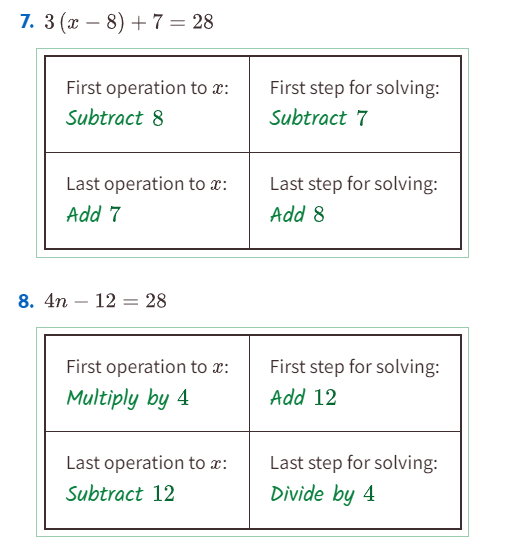

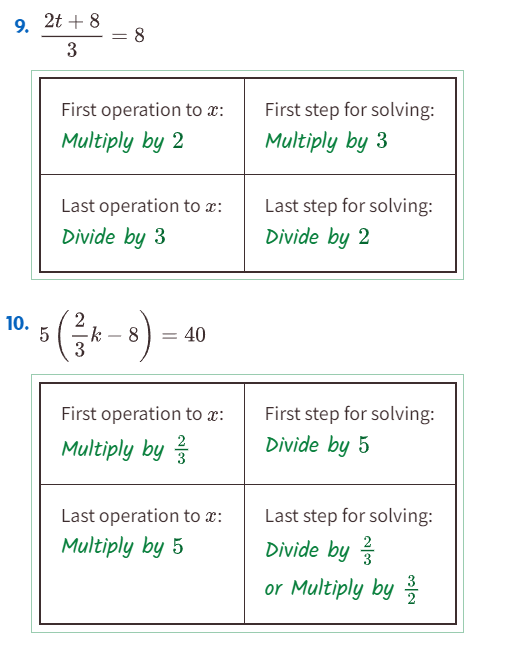

## AGS1.4.1.2 - Solve Each Equation And Check Steps.

### Option 1: Graph
#### instruction : Graph the following equations on the coordinate grid. Determine if the given point is a solution to the equation.


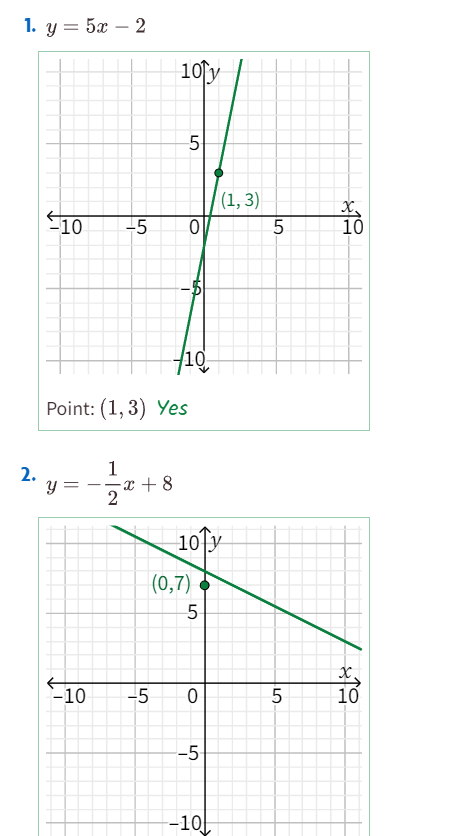

In [ ]:
def generate_point(graph_domain):
    return int(random.randint(graph_domain[0] + 1, graph_domain[1] - 1))

def checkBoundary(pointx,pointy,graph_domain,lineq):
    inDomain=False
    while inDomain == False:
        if pointy <= 0:
            while pointy < graph_domain[0]:
                pointx = generate_point(graph_domain); pointy = lineq.subs(pointx)
        else:
            while pointy > graph_domain[1]:
                pointx = generate_point(graph_domain); pointy = lineq.subs(pointx)
        if pointy > graph_domain[0] and pointy < graph_domain[1]: inDomain=True 

    return pointx,pointy


def Solve_Each_Equation_And_Check_Steps_PT1_4_1_2(option):
    if option == 1:
        graph_domain = [-10, 10]
        slope = random.randint(-6, 6) # add fraction funcionality
        yint = random.randint(-6, 6)
        lineq = LinFunc(slope, yint)
        on_line = random.choice([False, True])

        if random.randint(0,1) == 0:
            if on_line == True:
                pointx = generate_point(graph_domain); pointy = lineq.subs(pointx)
                pointx, pointy = checkBoundary(pointx,pointy,graph_domain,lineq)
            else:
                pointx = generate_point(graph_domain); pointy = generate_point(graph_domain)

            # A way to check if the dot really isnt on the graph
            while(on_line == False and (lineq.subs(pointx) == pointy)):
                pointx = generate_point(graph_domain); pointy = generate_point(graph_domain)
                pointx, pointy = checkBoundary(pointx,pointy,graph_domain,lineq)                

            header_graph = r'\newline '+fr'${lineq.getStdForm()}$'+startGraph(*graph_domain, *graph_domain)+drawLinear(
                lineq.expr, graph_domain[0], graph_domain[1])+drawPt([pointx, pointy])+endGraph()+r'\newline'

            problem = lineq.getStdForm(), emptyGraph(*graph_domain, *graph_domain)
            answer = "Yes" if on_line else "No"

        else:
            if on_line == True:
                pointx = generate_point(graph_domain); pointy = lineq.subs(pointx)
                pointx, pointy = checkBoundary(pointx,pointy,graph_domain,lineq)
            else:
                pointx = generate_point(graph_domain); pointy = generate_point(graph_domain)

            # A way to check if the dot really isnt on the graph
            while(on_line == False and (lineq.subs(pointx) == pointy)):
                pointx = generate_point(graph_domain); pointy = generate_point(graph_domain)
                pointx, pointy = checkBoundary(pointx,pointy,graph_domain,lineq)    

            header_graph = r'\newline '+fr'${lineq.getStdForm()}$'+startGraph(*graph_domain, *graph_domain)+drawLinear(
                lineq.expr, graph_domain[0], graph_domain[1])+drawPt([pointx, pointy])+endGraph()+fr'$ Point: ({pointx},{pointy}) $'+r'\newline'

            problem = lineq.getStdForm(), emptyGraph(*graph_domain, *graph_domain)
            answer = "Yes " + \
                fr"$ Point: ({pointx},{pointy}) $" if on_line else "No " + \
                fr"$ Point: ({pointx},{pointy}) $"

        return header_graph, problem[0], problem[1], answer

    elif option == 2:
        # here, utilize previous created functions that generate equations and 
        return


for i in range(20):
    a = Solve_Each_Equation_And_Check_Steps_PT1_4_1_2(1)
    print(*a)

### Option 2 : Equation
#### instruction : Indicate whether the given value is a solution to the corresponding equation. Show your work.

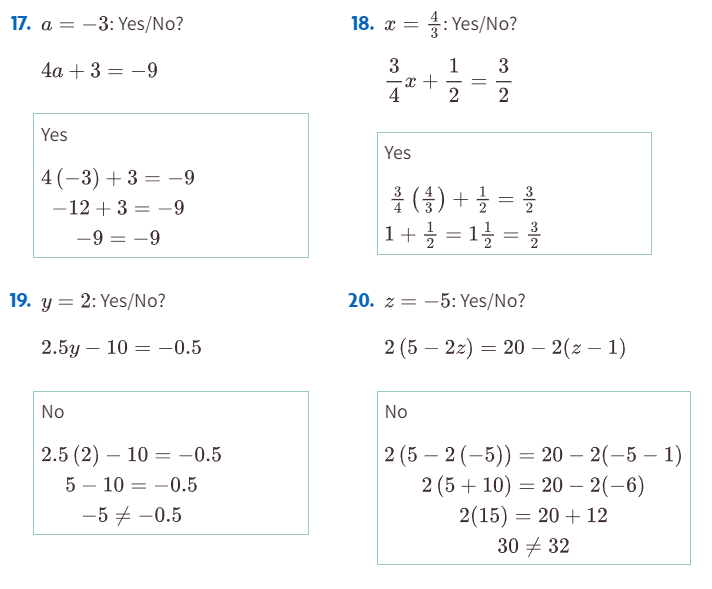

## AGS1.4.2.1 - Find The Domain And Range.

### Option 1: Simple
#### instruction : Find the domain and range for each function graphed below. Use interval notation to write your answer.


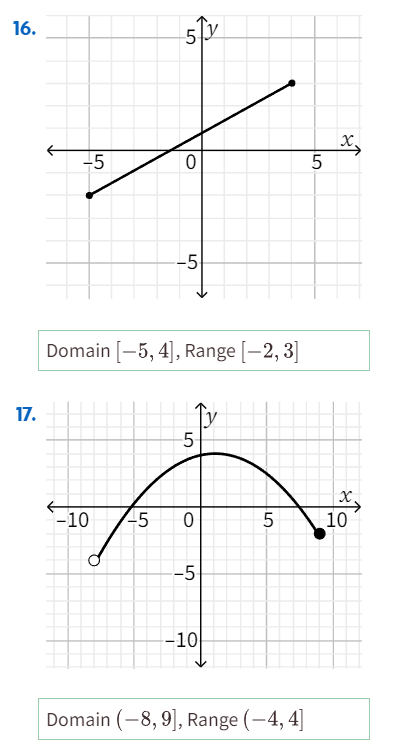

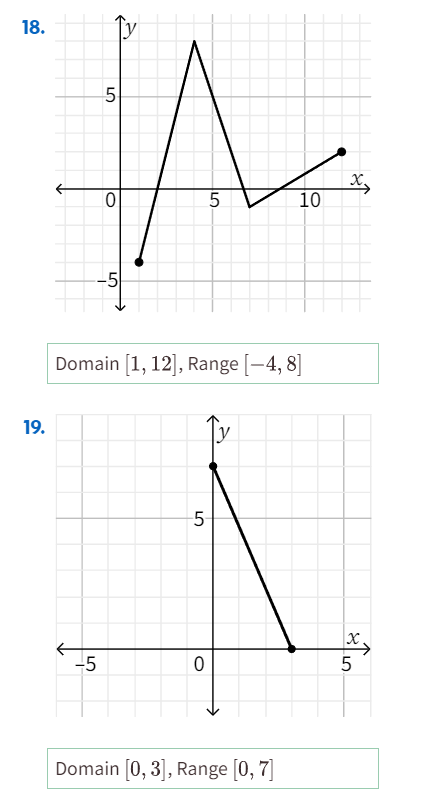

In [ ]:
def PWDomRange_4_2_1(pieces=randint(1,3), cont=True, expr='latex'):
    endPts, pairs = [randint(-8,-3)], []

    for jj in range(pieces):
        if jj == 0:
            start = randint(-8,8)
        else:
            if cont or randint(0,1):
                start = pairs[-1][0].subs(x,endPts[jj])
            else:
                start = randint(-8,8)
        
        kind = randint(1,2)         # No exponential pieces yet
        if kind == 1:               # Linear
            slope = Rational(getInt(-6,6),randint(1,3))
            func = LinFunc(slope, [endPts[jj],start])
            step = randint(3,6) if slope.q==1 else randint(1,3)*slope.q
        elif kind == 2:             # Quadratic
            step = randint(2,4)
            func = QuadFunc.from2Pts(1, [endPts[jj],start], [endPts[jj]+step,start+randint(-4,4)])
        else:                       # Exponential           TODO: Fix exponential pieces
            step = randint(2,4)
            func = ExpFunc(Rational(1,randint(2,5)), [endPts[jj],start])
        
        endPts.append(endPts[jj] + step)
        interval = f'{endPts[jj]},{endPts[jj+1]}'
        if jj == 0:
            interval = ('(' + interval) if randint(0,1) else ('[' + interval)
        else:                       # Make sure intervals don't overlap
            if cont:
                interval = '[' + interval
            else:
                interval = ('(' + interval) if (pairs[-1][1][-1]==']' or randint(0,1)) else ('[' + interval)
        interval += ')' if (cont or randint(0,1)) else ']'

        expression = func.expr if type(func)!=ExpFunc else func.subs(func.variable-endPts[jj])*func.base**endPts[jj]
        pairs.append([expression, interval])
    
    func = PWFunc(*pairs)

    problem = graphPW(func, contDot=False)
    answer = func.printFeats(['domain','range'])

    return problem, answer

for jj in range(5):
    problem, answer = PWDomRange_4_2_1(randint(1,3), cont=True)
    print(problem)
    print(answer)

\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-11,xmax=11,xtick={-15,-10,...,16},ymin=-26,ymax=6,ytick={-30,-25,...,11},]\addplot[black,solid,thick,domain=-8:-3,samples=100] {-2*x - 15};\fill[draw=black,fill=white] (axis cs: -8,1) circle(2pt);\addplot[black,solid,thick,domain=-3:1,samples=100] {-3*x - 18};\addplot[black,solid,thick,domain=1:5,samples=100] {x^2 - 11*x/2 - 33/2};\fill[draw=black,fill=white] (axis cs: 5,-19) circle(2pt);\end{axis}\end{tikzpicture}
Domain: $\left(-8, 5\right)$ \newline Range: $\left[-24.1, 1.0\right)$ \newline 
\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-11,xmax=1,xtick={-15,-10,...,6},ymin=-16,ymax=1,ytick={-20,-15,...,6},]\addplot[black,solid,thick,domain=-7:-5,samples=100] {x^2 + 10*x + 13};\fill[draw=black,fill=black] (axis cs: -7,-8) circle(2pt);\fill[draw=black,fill=white] (axis cs: -5,-12) circle(2pt);\end{axis}\end{tikzpicture}
Domain: $\left[-7, -5\right)$ \newline Range: $\left(-12, -8\right]$ \newline 
\begin{tikzpicture}\begin{ax

## AGS1.4.2.2 - Graph Inequality

### Option 1: Simple
#### instruction : For each of the inequalities, graph the values being described on the numbers lines.

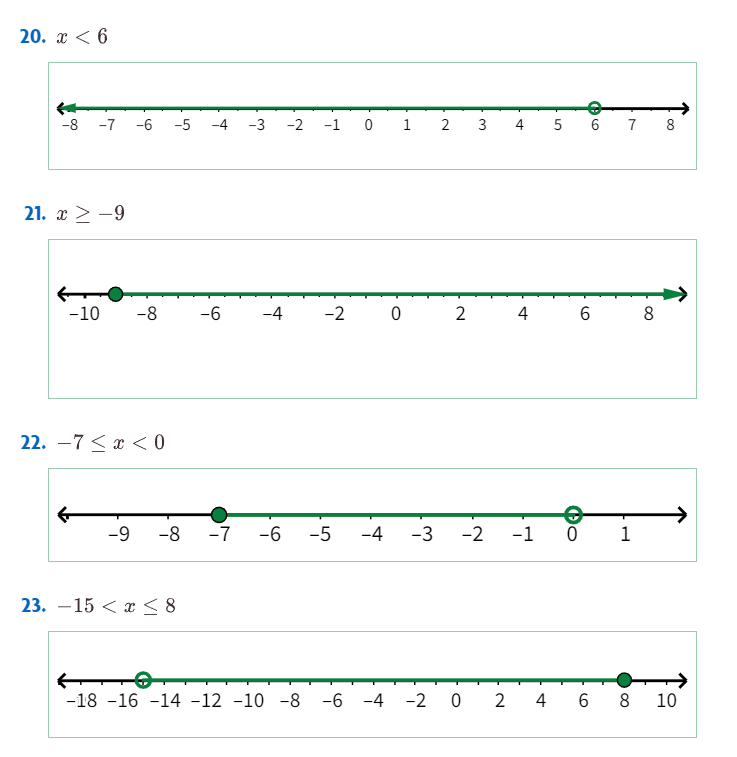

In [ ]:
def graphInequal_4_2_2():
    start = randint(-20,10) if randint(0,9) else -oo
    if randint(0,9):
        end = (start+randint(10,30)) if start!=-oo else randint(-10,10)
    else:
        end = choice([start+randint(10,30), oo]) if start!=-oo else randint(-10,10)    
    interval = makeInterval(choice(['(','[']) + f'{start},{end}' + choice([')',']']))

    problem = signify(latex(interval.as_relational(x)))

    answer,_ = graphSet(interval)

    return problem, answer

for jj in range(10):
    problem, answer = graphInequal_4_2_2()
    print(problem, r'\\')
    print(answer)

$x < 4$ \\
\begin{tikzpicture}\begin{axis}[mmt numline style,xmin=-1,xmax=6,xtick={-5,0,...,11}]\addplot[red,ultra thick,latex-,domain=-1:4] {0};\fill[draw=black,fill=white] (axis cs: 4,0) circle(2pt);\end{axis}\end{tikzpicture}
$4 \leq x \wedge x \leq 26$ \\
\begin{tikzpicture}\begin{axis}[mmt numline style,xmin=-1,xmax=31,xtick={-5,0,...,36}]\addplot[red,ultra thick,-,domain=4:26] {0};\fill[draw=black,fill=black] (axis cs: 4,0) circle(2pt);\fill[draw=black,fill=black] (axis cs: 26,0) circle(2pt);\end{axis}\end{tikzpicture}
$-5 < x \wedge x < 22$ \\
\begin{tikzpicture}\begin{axis}[mmt numline style,xmin=-6,xmax=26,xtick={-10,-5,...,31}]\addplot[red,ultra thick,-,domain=-5:22] {0};\fill[draw=black,fill=white] (axis cs: -5,0) circle(2pt);\fill[draw=black,fill=white] (axis cs: 22,0) circle(2pt);\end{axis}\end{tikzpicture}
$-1 < x$ \\
\begin{tikzpicture}\begin{axis}[mmt numline style,xmin=-6,xmax=1,xtick={-10,-5,...,6}]\addplot[red,ultra thick,-latex,domain=-1:1] {0};\fill[draw=black,fill

## AGS1.4.2.3 - Solve For The Variable.

### Option 1: Easy
#### instruction : Solve for the indicated variable. Show your work!



case 1: Solve for $VAR1$

$VAR1 = intA * VAR2 + intB$

----

case 2: Solve for $VAR2$

$VAR1 = VAR2 * VAR3 + intB$

---

case 3: solve for $VAR1$

$\frac{VAR1 + intA}{intB} = intC$

---

case 4: solve for $VAR1$

$\frac{VAR1 + intA}{intB} = intC$

---

case 5: solve for $VAR1$

$\frac{VAR1 + intA * VAR2}{intB} = intC$





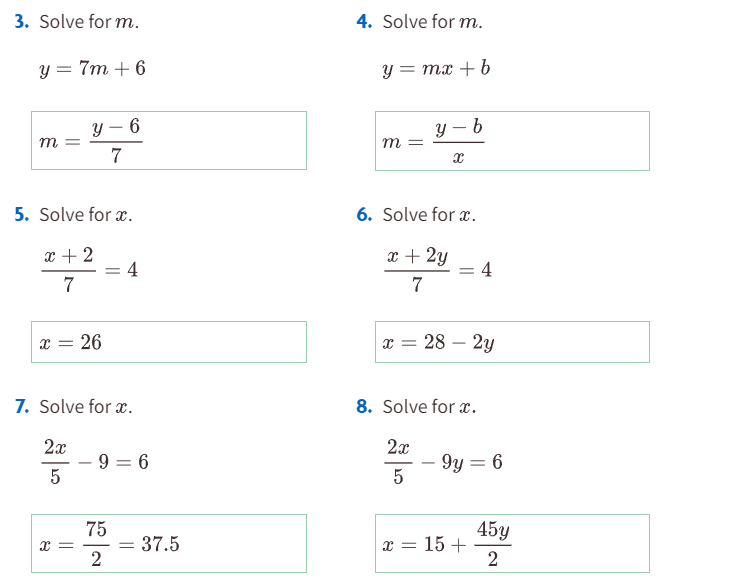

In [ ]:
"""
This section generates equations and solves them. 
  Return Parameters: 
      Question Prompt e.g "Solve for x"
      Problem question(in latex friendly format) e.g "\frac{x}{5} = 6" 
      Answer(also in latex friendly format) e.g "x = 30"

Some of the cases could be optimized using reduce or map
This applies to all easy, medium, hard (1.4.2.3)
"""
import sympy as sp; import random

def equation_packager(output, other, x):
    equation= sp.Eq(sp.sympify(output), sp.sympify(other))
    return sp.latex(equation), sp.solve(equation, x)
def answer_packager(x, answerset):
    return sp.latex(sp.Eq(sp.sympify(x), sp.sympify(answerset[0])))
def q_prompt(x):
    return fr"Solve for ${x}$"

def One_step_Equations_With_Integers_1(option_difficulty):
    problemsets = ""
    answerset = ""
    choices = ['x', 'y', 'a', 'b', 'z', 'p', 't', 'q', 'k', 'u', 'r', 'd', 'w', 's', 'h', 'v']
    addition_expression = ['+', '-']
    negative = ['-', '']
    temp = random.choice([1, 2, 3])
    variables = []
    variable_values = []
    numerals = []
    pass_loop = False
    unique = []
    if temp == 1: 
        variables.append(random.choice(choices))
        sym_1 = random.choice(addition_expression)
        numerals.append(str(random.randint(2, 10))) if option_difficulty=="easy" else (numerals.append(str(random.randint(2, 30))) if option_difficulty=="medium" else numerals.append(str(random.randint(20, 50))))
        numerals.append(str(random.choice(negative))+str(random.randint(1, 10))) if option_difficulty=="easy" else (numerals.append(str(random.choice(negative))+str(random.randint(1, 60))) if option_difficulty=="medium" else numerals.append(str(random.choice(negative))+str(random.randint(20, 90))))
        x = sp.symbols(str(variables[0]))
        output = '{} {} {}'.format(str(variables[0]), sym_1, str(numerals[0])) if random.randint(1,2) == 1 else '{} {} {}'.format(str(numerals[0]), sym_1, str(variables[0]))
        other = '{}'.format(str(numerals[1]))
        problemsets, answerset = equation_packager(output, other, x)

    elif temp == 2:
        while pass_loop == False:
            variables.clear()
            variable_values.clear()
            numerals.clear()
            variables.append(random.choice(choices))
            variable_values.append(str(random.choice(negative)) + str(random.randint(2,10))) if option_difficulty=="easy" or option_difficulty=="medium" else variable_values.append(str(random.choice(negative)) + str(random.randint(5,15)))
            for i in range(1, int(abs(int(variable_values[0])) / 2) + 1):
                if int(abs(int(variable_values[0]))) % i == 0:
                    if i not in unique:
                        unique.append(i)
                    if int(abs(int(variable_values[0]))/i) not in unique:
                        unique.append(int(abs(int(variable_values[0])) / i))
            holder = random.choice(unique[1:])
            randomized = holder * random.randint(5, 10) if option_difficulty=="easy" else (holder * random.randint(5, 15) if option_difficulty=="medium" else holder * random.randint(10, 20))
            if randomized % int(variable_values[0]) != 0:
                randomized = randomized + (randomized % int(variable_values[0]))
            numerals.append(str(random.choice(negative)) + str(randomized))
            x = sp.symbols(str(variables[0]))
            output, other = '{}*{}'.format(str(variable_values[0]), str(variables[0])), '{}'.format(str(numerals[0]))
            problemsets, answerset = equation_packager(output, other, x)
            output = str(answerset)
            output = output.replace('[', ''); output = output.replace(']', '')
            pass_loop = sp.sympify(output).is_integer

    elif temp == 3:
        variables.append(random.choice(choices))
        variable_values.append(str(random.choice(negative))+str(random.randint(2,10))) if option_difficulty=="easy" or option_difficulty=="medium" else variable_values.append(str(random.choice(negative))+str(random.randint(5,15)))
        numerals.append(str(random.choice(negative))+str(random.randint(2,15))) if option_difficulty=="easy" else (numerals.append(str(random.choice(negative))+str(random.randint(2,60))) if option_difficulty=="medium" else numerals.append(str(random.choice(negative))+str(random.randint(20,90))))
        x = sp.symbols(str(variables[0]))
        output, other = '{} / {}'.format(str(variables[0]), str(variable_values[0])), '{}'.format(str(numerals[0]))
        problemsets, answerset = equation_packager(output, other, x)
    
    return(q_prompt(x), problemsets, answer_packager(x, answerset))

def Two_step_Equations_With_Integers_1(option_difficulty = 'easy'):
    problemsets = ""
    answerset = ""
    choices = ['x', 'y', 'a', 'b', 'z', 'p', 't', 'q', 'k', 'u', 'r', 'd', 'w', 's', 'h', 'v']
    addition_expression = ['+', '-']
    negative = ['-', '']
    temp = random.choice([1, 2])
    variables = []
    variable_values = []
    numerals = []
    pass_loop = False
    if option_difficulty == "easy":
        if temp == 1:
            while pass_loop == False:
                variables.clear()
                variable_values.clear()
                numerals.clear()
                variables.append(random.choice(choices))
                sym_1 = random.choice(addition_expression)
                numerals.append(str(random.randint(2, 10)))
                numerals.append(str(random.choice(negative)) + str(random.randint(1, 10)))
                numerals.append(str(random.choice(negative)) + str(random.randint(2, 10)))
                x = sp.symbols(str(variables[0]))
                output = '{}*{} {} {}'.format(str(numerals[2]), str(variables[0]), sym_1, str(numerals[0])) if random.randint(1,2) == 1 else '{} {} {}*{}'.format(str(numerals[0]), sym_1, str(numerals[2]), str(variables[0]))
                other = '{}'.format(str(numerals[1]))
                equation = sp.Eq(sp.sympify(output), sp.sympify(other))
                problemsets= sp.latex(equation)
                answerset= sp.solve(equation, x)
                pass_loop = sp.sympify(sp.solve(equation, x).pop(0)).is_integer

        elif temp == 2:
            variables.append(random.choice(choices))
            variable_values.append(str(random.choice(negative)) + str(random.randint(2,10)))
            numerals.append(str(random.choice(negative)) + str(random.randint(2,15)))
            numerals.append(str(random.randint(2,15)))
            sym_1 = random.choice(addition_expression)
            x = sp.symbols(str(variables[0]))
            output, other = '{} / {} {} {}'.format(str(variables[0]), str(variable_values[0]), sym_1, str(numerals[1])), '{}'.format(str(numerals[0]))
            problemsets, answerset = equation_packager(output, other, x)

    elif option_difficulty == "medium":
        if temp == 1:
            variables.clear()
            variable_values.clear()
            numerals.clear()
            variables.append(random.choice(choices))
            numerals.append(str(random.randint(2, 20)))
            numerals.append(str(random.randint(2, 20)))
            numerals.append(str(random.choice(negative)) +  str(random.randint(1, 40)))
            x = sp.symbols(str(variables[0]))
            output, other = '({} / {}) * {}'.format(str(numerals[0]), str(numerals[1]), str(variables[0])), '{}'.format(str(numerals[2]))
            problemsets, answerset = equation_packager(output, other, x)

        elif temp == 2:
            variables.clear()
            variable_values.clear()
            numerals.clear()
            variables.append(random.choice(choices))
            numerals.append(str(random.randint(2, 20)))
            numerals.append(str(random.randint(2, 20)))
            numerals.append(str(random.randint(1, 30)))
            numerals.append( str(random.randint(2, 30)))
            x = sp.symbols(str(variables[0]))
            output, other = '({} / {}) * {}'.format(str(numerals[0]), str(numerals[1]), str(variables[0])), '{} / {}'.format(str(numerals[2]), str(numerals[3]))
            problemsets, answerset = equation_packager(output, other, x)


    elif option_difficulty == "hard":
        if temp == 1:
            variables.clear()
            variable_values.clear()
            numerals.clear()
            variables.append(random.choice(choices))
            numerals.append(str(random.randint(15, 30)))
            numerals.append(str(random.randint(15, 30)))
            numerals.append(str(random.choice(negative)) + str(random.randint(30, 60)))
            x = sp.symbols(str(variables[0]))
            output, other = '({} / {}) * {}'.format(str(numerals[0]), str(numerals[1]), str(variables[0])), '{}'.format(str(numerals[2]))
            problemsets, answerset = equation_packager(output, other, x)

        elif temp == 2:
            variables.clear()
            variable_values.clear()
            numerals.clear()
            variables.append(random.choice(choices))
            numerals.append(str(random.randint(15, 30)))
            numerals.append(str(random.randint(15, 30)))
            numerals.append(str(random.randint(15, 30)))
            numerals.append(str(random.randint(15, 30)))
            x = sp.symbols(str(variables[0]))
            output, other = '({} / {}) * {}'.format(str(numerals[0]), str(numerals[1]), str(variables[0])), '{} / {}'.format(str(numerals[2]), str(numerals[3]))
            problemsets, answerset = equation_packager(output, other, x)
    return(q_prompt(x), problemsets, answer_packager(x, answerset))

def additional_eq():
    case= random.randint(1,4)
    choices = ['x', 'y', 'a', 'b', 'z', 'p', 't', 'q', 'k', 'u', 'r', 'd', 'w', 's', 'h', 'v']
    addition_expression = ['+', '-']
    negative = ['-', '']
    problemsets = ""
    answerset = ""
    numerals = []
    if case == 1:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var2))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(0, 15)))
        output= "{}".format(var1)
        other= "{}*{} {} {}".format(numerals[0], var2, sym_1, numerals[1]) if numerals[1] != 0 else "{}*{}".format(numerals[0], var2)
        problemsets, answerset = equation_packager(output, other, x)

    elif case == 2:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        var3= random.choice(choices)
        while var3 in var1 or var3 in var2:
            var3= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var2))
        numerals.append(str(random.randint(0, 15)))
        output= "{}".format(var1)
        other= "{}*{} {} {}".format(var2, var3, sym_1, numerals[0]) if numerals[0] != 0 else "{}*{}".format(var2, var3)
        problemsets, answerset = equation_packager(output, other, x)

    elif case == 3:
        var1= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var1))
        numerals.append(str(random.randint(0, 15)))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(random.choice(negative)+str(random.randint(0, 15)))
        output= '({} {} {}) / ({})'.format(var1, sym_1, numerals[0], numerals[1]) if numerals[0] != 0 else '({}) / ({})'.format(var1, numerals[1])
        other= "{}".format(numerals[2])
        problemsets, answerset = equation_packager(output, other, x)

    elif case == 4:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var1))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(random.choice(negative)+str(random.randint(0, 15)))
        output= '({} {} {}*{}) / ({})'.format(var1, sym_1, numerals[0], var2, numerals[1])
        other= "{}".format(numerals[2])
        problemsets, answerset = equation_packager(output, other, x)

    return q_prompt(x), problemsets, answer_packager(x, answerset)

for i in range(10):
    prompt, problem, answer = random.choice([additional_eq(),One_step_Equations_With_Integers_1(random.choice(["easy", "medium", "hard"])), Two_step_Equations_With_Integers_1(random.choice(["easy", "medium", "hard"]))])
    print(prompt, " - - - - - ", problem, " - - - - - ",answer)


Solve for $b$  - - - - -  - 8 b - 3 = -3  - - - - -  b = 0
Solve for $s$  - - - - -  - \frac{s}{3} - 12 = 7  - - - - -  s = -57
Solve for $b$  - - - - -  z = 10 b - 12  - - - - -  b = \frac{z}{10} + \frac{6}{5}
Solve for $d$  - - - - -  - \frac{d}{4} - 7 = -4  - - - - -  d = -12
Solve for $b$  - - - - -  - \frac{b}{4} + \frac{7 h}{4} = 0  - - - - -  b = 7 h
Solve for $a$  - - - - -  a + 6 = -7  - - - - -  a = -13
Solve for $h$  - - - - -  h - 22 = 14  - - - - -  h = 36
Solve for $v$  - - - - -  11 v = -198  - - - - -  v = -18
Solve for $p$  - - - - -  \frac{7 p}{5} = 37  - - - - -  p = \frac{185}{7}
Solve for $d$  - - - - -  2 d = -28  - - - - -  d = -14


### Option 2: Medium
#### instruction : Solve for the indicated variable. Show your work!

---
case 1:



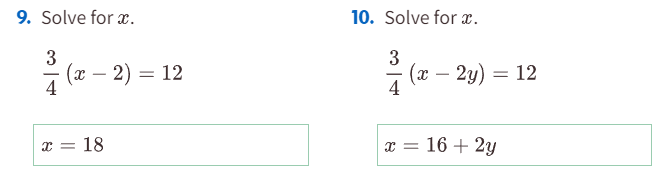

---
case 1: solve for var1

$$VAR1 ( VAR2 + VAR3)) =  \frac{intA * VAR4}{VAR2}$$

---
case 2: solve for var3

$$VAR1 ( VAR2 + intA * VAR3)) =  \frac{VAR4}{VAR2}$$

---

case 3: solve for $VAR1$

$$\frac{intA*VAR1}{intB} - intC = intD$$

---

case 4: solve for $VAR1$

$$\frac{intA*VAR1}{intB} - intC *VAR2= intD$$
---



In [ ]:
import sympy as sp; import random

def equation_packager(output, other, x):
    equation= sp.Eq(sp.sympify(output), sp.sympify(other))
    return sp.latex(equation), sp.solve(equation, x)
def answer_packager(x, answerset):
    return sp.latex(sp.Eq(sp.sympify(x), sp.sympify(answerset[0])))
def q_prompt(x):
    return fr"Solve for ${x}$"

def additional_eq_medium():
    case= random.randint(1,4)
    choices = ['x', 'y', 'a', 'b', 'z', 'p', 't', 'q', 'k', 'u', 'r', 'd', 'w', 's', 'h', 'v']
    addition_expression = ['+', '-']
    negative = ['-', '']
    problemsets = ""
    answerset = ""
    numerals = []
    if case == 1:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        var3= random.choice(choices)
        while var3 in var1 or var3 in var2:
            var3= random.choice(choices)
        var4= random.choice(choices)
        while var4 in var1 or var4 in var2 or var4 in var3:
            var4= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var1))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        output= "{} * ({} {} {})".format(var1, var2, sym_1, var3)
        other= "({}*{}) / ({})".format(numerals[0], var4, var2)
        problemsets, answerset = equation_packager(output, other, x)

    elif case == 2:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        var3= random.choice(choices)
        while var3 in var1 or var3 in var2:
            var3= random.choice(choices)
        var4= random.choice(choices)
        while var4 in var1 or var4 in var2 or var4 in var3:
            var4= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var3))
        numerals.append(str(random.randint(1, 15)))
        output= "{} * ({} {} {} * {})".format(var1, var2, sym_1, numerals[0], var3)
        other= "({}) / ({})".format(var4, var2)
        problemsets, answerset = equation_packager(output, other, x)        

    elif case == 3:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var1))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(str(random.randint(0, 15)))
        numerals.append(str(random.randint(0, 15)))
        output= "({} * {}) / ({}) {} {}".format(numerals[0], var1, numerals[1], sym_1, numerals[2])
        other= "{}".format(numerals[3])
        problemsets, answerset = equation_packager(output, other, x)  

    elif case == 4:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var1))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(str(random.randint(0, 15)))
        numerals.append(str(random.randint(1, 15)))
        output= "({} * {}) / ({}) {} {} * {}".format(numerals[0], var1, numerals[1], sym_1, numerals[2], var2)
        other= "{}".format(numerals[3])
        problemsets, answerset = equation_packager(output, other, x)  

    return q_prompt(x), problemsets, answer_packager(x, answerset)

for i in range(20):
    prompt, problem, solution= additional_eq_medium()
    print(prompt, " - - - - - ", problem, " - - - - - ", solution)

Solve for $h$  - - - - -  h \left(p + z\right) = - \frac{5 q}{z}  - - - - -  h = - \frac{5 q}{z \left(p + z\right)}
Solve for $b$  - - - - -  y \left(- 2 b + t\right) = \frac{r}{t}  - - - - -  b = - \frac{r}{2 t y} + \frac{t}{2}
Solve for $r$  - - - - -  r \left(t + z\right) = - \frac{15 h}{t}  - - - - -  r = - \frac{15 h}{t \left(t + z\right)}
Solve for $d$  - - - - -  h \left(- 7 d + p\right) = \frac{u}{p}  - - - - -  d = \frac{p}{7} - \frac{u}{7 h p}
Solve for $z$  - - - - -  p \left(b + 4 z\right) = \frac{a}{b}  - - - - -  z = \frac{a}{4 b p} - \frac{b}{4}
Solve for $t$  - - - - -  9 s - 5 t = 11  - - - - -  t = \frac{9 s}{5} - \frac{11}{5}
Solve for $x$  - - - - -  q \left(s + 15 x\right) = \frac{b}{s}  - - - - -  x = \frac{b}{15 q s} - \frac{s}{15}
Solve for $s$  - - - - -  s \left(b - r\right) = - \frac{10 a}{b}  - - - - -  s = \frac{10 a}{b \left(- b + r\right)}
Solve for $p$  - - - - -  - \frac{7 p}{3} - 10 w = 3  - - - - -  p = - \frac{30 w}{7} - \frac{9}{7}
Solve for $z$  - 

### Option 3: Hard
#### instruction : Solve for the indicated variable. Show your work!

Problem Solve for $VAR$

case 1: solve for $VAR1$

$ \frac{intA}{intB}(\frac{intC*VAR1}{intD} - intE) = intF$

case 2: solve for $VAR2$

$ \frac{intA}{intB}(\frac{intC*VAR1}{intD} - VAR2) = intE$

case 3: solve for $VAR1$

$ \frac{intA}{intB}(\frac{intC*VAR1}{intD} - VAR2) = intE$

case 4: 

$ \frac{intA}{intB}(\frac{intC*VAR1}{intD} - VAR2) = intE$



In [ ]:
import sympy as sp; import random

def equation_packager(output, other, x):
    equation= sp.Eq(sp.sympify(output), sp.sympify(other))
    return sp.latex(equation), sp.solve(equation, x)
def answer_packager(x, answerset):
    return sp.latex(sp.Eq(sp.sympify(x), sp.sympify(answerset[0])))
def q_prompt(x):
    return fr"Solve for ${x}$"

def additional_eq_hard():
    case= random.randint(1,3)
    choices = ['x', 'y', 'a', 'b', 'z', 'p', 't', 'q', 'k', 'u', 'r', 'd', 'w', 's', 'h', 'v']
    addition_expression = ['+', '-']
    negative = ['-', '']
    problemsets = ""
    answerset = ""
    numerals = []
    if case == 1:
        var1= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var1))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(str(random.randint(0, 15)))
        output= "({})/({}) * (({}*{})/({}) {} {})".format(numerals[0], numerals[1], numerals[2], var1, numerals[3], sym_1, numerals[4])
        other= "{}".format(numerals[5])
        problemsets, answerset = equation_packager(output, other, x)

    elif case == 2 or case == 3:
        var1= random.choice(choices)
        var2= random.choice(choices)
        while var2 in var1:
            var2= random.choice(choices)
        sym_1= random.choice(addition_expression)
        x= sp.symbols(str(var2)) if case == 2 else sp.symbols(str(var1))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(random.choice(negative)+str(random.randint(1, 15)))
        numerals.append(str(random.randint(1, 15)))
        numerals.append(str(random.randint(0, 15)))
        output= "({})/({}) * (({}*{})/({}) {} {})".format(numerals[0], numerals[1], numerals[2], var1, numerals[3], sym_1, var2)
        other= "{}".format(numerals[4])
        problemsets, answerset = equation_packager(output, other, x)        
    
    return q_prompt(x), problemsets, answer_packager(x, answerset)
for i in range(20):
    prompt, problem, solution= additional_eq_hard()
    print(prompt, " - - - - - ", problem, " - - - - - ", solution)

Solve for $q$  - - - - -  \frac{120 q}{13} + \frac{225}{13} = 11  - - - - -  q = - \frac{41}{60}
Solve for $b$  - - - - -  6 b - 8 = 15  - - - - -  b = \frac{23}{6}
Solve for $a$  - - - - -  - \frac{11 a}{2} + \frac{99 z}{8} = 7  - - - - -  a = \frac{9 z}{4} - \frac{14}{11}
Solve for $s$  - - - - -  - \frac{117 s}{40} - \frac{13 u}{10} = 15  - - - - -  s = - \frac{4 u}{9} - \frac{200}{39}
Solve for $v$  - - - - -  - \frac{169 v}{96} - \frac{39}{2} = 1  - - - - -  v = - \frac{1968}{169}
Solve for $u$  - - - - -  - \frac{11 p}{12} - \frac{11 u}{120} = 15  - - - - -  u = - 10 p - \frac{1800}{11}
Solve for $y$  - - - - -  - \frac{16 s}{49} - \frac{4 y}{7} = 4  - - - - -  y = - \frac{4 s}{7} - 7
Solve for $q$  - - - - -  - \frac{5 b}{12} - \frac{5 q}{12} = 12  - - - - -  q = - b - \frac{144}{5}
Solve for $k$  - - - - -  - \frac{2 k}{5} + \frac{6 w}{25} = 1  - - - - -  k = \frac{3 w}{5} - \frac{5}{2}
Solve for $w$  - - - - -  - \frac{a}{6} + \frac{11 w}{36} = 8  - - - - -  w = \frac{6 a}{11}